In [ ]:
# This class tests whether the tensorflow and autograd versions give identical outputs for a simple least squared loss function

In [13]:
from autograd import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
from optimizers.autograd.lma import LMA as LMAag
from optimizers.tensorflow.lma import LMA as LMAtf

In [14]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
z_true = np.random.randn(3,10).astype('float32')

random_mat = np.random.randn(3,3)
random_symmetric_mat = random_mat + random_mat.T
evals, evecs = np.linalg.eig(random_symmetric_mat)
affine_transform = evecs

y_true = affine_transform @ z_true
y_true_flat = y_true.flatten()

In [16]:
def y_pred(z_flat):
    z_arr = np.reshape(z_flat, (3, -1))
    return (affine_transform @ z_arr).flatten()

def loss_fn(y):
    return 0.5 * np.sum((y - y_true_flat)**2)

In [17]:
z_guess = np.random.randn(30).astype('float32')

In [18]:
# Testing the autograd implementations

In [19]:
ag_lma1 = LMAag(z_guess, y_pred, loss_fn, squared_loss=True, damping_factor=1., cg_tol=1e-5)
ag_lma2 = LMAag(z_guess, y_pred, loss_fn, squared_loss=False, damping_factor=1., cg_tol=1e-5)

In [20]:
ag_losses1 = []
ag_losses2 = []
for i in range(10):
    out1 = ag_lma1.minimize()
    out2 = ag_lma2.minimize()
    print(i, loss_fn(y_pred(out1)), loss_fn(y_pred(out2)))
    ag_losses1.append(loss_fn(y_pred(out1)))
    ag_losses2.append(loss_fn(y_pred(out2)))

0 8.502004983005312 8.502004983005312
1 2.125501245751329 2.125501245751329
2 0.5313753114378322 0.5313753114378322
3 0.13284382785945809 0.13284382785945809
4 0.033210956964864646 0.033210956964864646
5 0.008302739241216142 0.008302739241216142
6 0.0020756848103040257 0.0020756848103040257
7 0.0005189212025760041 0.0005189212025760041
8 0.0001297303006440012 0.0001297303006440012
9 3.24325751609987e-05 3.24325751609987e-05


In [21]:
# Tensorflow test

In [24]:
tf.reset_default_graph()
var1 = tf.get_variable('var1', dtype=tf.float32, initializer=z_guess)
var2 = tf.get_variable('var2', dtype=tf.float32, initializer=z_guess)

tf_y_true = tf.convert_to_tensor(y_true_flat, dtype='float32', name='y_true')
tf_affine_transform = tf.convert_to_tensor(affine_transform, dtype='float32', name='affine_transform')

def tf_y_pred(z):
    return tf.reshape(tf_affine_transform @ tf.reshape(z, [3, -1]), [-1])
def tf_loss(y_pred):
    return 0.5 * tf.reduce_sum((tf_y_true - y_pred)**2)

preds1 = tf_y_pred(var1)
preds2 = tf_y_pred(var2)
loss_tensor1 = tf_loss(preds1)
loss_tensor2 = tf_loss(preds2)

tf_lma1 = LMAtf(var1, tf_y_pred, tf_loss, name='opt1', squared_loss=True, cg_tol=1e-5)
tf_lma2 = LMAtf(var2, tf_y_pred, tf_loss, name='opt2', squared_loss=False, cg_tol=1e-5)

tf_lma1_min = tf_lma1.minimize()
tf_lma2_min = tf_lma2.minimize()
session = tf.Session()
session.run(tf.global_variables_initializer())

In [25]:
tf_losses1 = []
tf_losses2 = []
for i in range(10):
    session.run([tf_lma1_min, tf_lma2_min])
    lossval1, lossval2 = session.run([loss_tensor1, loss_tensor2])
    print(i, lossval1, lossval2)
    tf_losses1.append(lossval1)
    tf_losses2.append(lossval2)
    

0 8.502005 8.502005
1 2.1255014 2.1255014
2 0.5313753 0.5313753
3 0.1328439 0.1328439
4 0.03321096 0.03321096
5 0.0083027575 0.0083027575
6 0.0020756866 0.0020756866
7 0.00051891815 0.00051891815
8 0.00012973158 0.00012973158
9 3.243199e-05 3.243199e-05


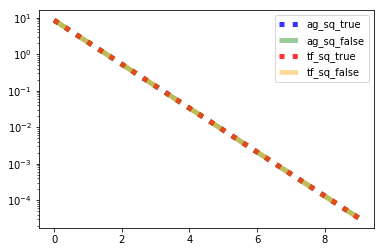

In [26]:
plt.plot(ag_losses1, color='blue', ls=':', linewidth=5.0, alpha=0.8, label='ag_sq_true')
plt.plot(ag_losses2, color='green', ls='--', linewidth=5.0, alpha=0.4, label='ag_sq_false')
plt.plot(tf_losses1, color='red', ls=':', linewidth=5.0, alpha=0.8, label='tf_sq_true')
plt.plot(tf_losses2, color='orange', ls='--', linewidth=5.0, alpha=0.4, label='tf_sq_false')
plt.yscale('log')
plt.legend(loc='best')
plt.show()